### 0. Import Libraries and Packages

In [76]:
import pandas as pd
import numpy as np
import sklearn
import string
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lookups import Lookups
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.sklearn

%matplotlib inline

### 1. Load Metacritic Album Review Data


In [4]:
df = pd.read_csv('clean_users.csv', engine='python')

In [5]:
df1 = pd.read_csv('clean_critics.csv', engine='python')

In [6]:
df = df.drop(columns = 'Unnamed: 0')
df1 = df1.drop(columns = 'Unnamed: 0')

In [7]:
df.head()

,title,artist,label,release_date,metascore,user_score,genre,summary,name,date,...,review,clean_review,length,word_count,sentiment,negative,neutral,positive,sent_class,rating_sent
0,Continuum,John Mayer,Sony,2006-09-12,67.0,8.9,Adult Alternative,The singer-songwriter's first album in three y...,ibadukefan,2014-02-02,...,This is John Mayer in the zone. This is where...,john mayer zone lives kind making rest career ...,441.0,83.0,-0.3761,0.154,0.728,0.118,-1.0,1.0
1,Continuum,John Mayer,Sony,2006-09-12,67.0,8.9,Adult Alternative,The singer-songwriter's first album in three y...,ToddW,2006-09-27,...,"I give Little, Good John kudos for at least t...",give little good john kudos least turning ligh...,575.0,102.0,-0.3651,0.222,0.576,0.202,-1.0,-1.0
2,Continuum,John Mayer,Sony,2006-09-12,67.0,8.9,Adult Alternative,The singer-songwriter's first album in three y...,ChristopherG.,2007-08-01,...,John Mayer... oh John Mayer. A talented blues...,john mayer oh john mayer talented bluesguitari...,653.0,117.0,0.9371,0.057,0.678,0.266,1.0,-1.0
3,Continuum,John Mayer,Sony,2006-09-12,67.0,8.9,Adult Alternative,The singer-songwriter's first album in three y...,jfrotylpe532,2012-12-21,...,John Mayer brings a great sounding album as a ...,john mayer brings great sounding matter fact w...,108.0,20.0,0.7964,0.000,0.497,0.503,1.0,1.0
4,Continuum,John Mayer,Sony,2006-09-12,67.0,8.9,Adult Alternative,The singer-songwriter's first album in three y...,ErinY,2006-09-12,...,It is great to have John Mayer back. This alb...,great john mayer back definitely best really s...,123.0,22.0,0.9001,0.000,0.389,0.611,1.0,1.0


In [8]:
df1.head()

,title,artist,label,release_date,metascore,user_score,genre,summary,name,date,...,clean_review,length,word_count,sentiment,negative,neutral,positive,sent_class,rating_sent,sp_lm
0,The Wanting,Glenn Jones,Thrill Jockey,2011-09-13,77.0,tbd,Adult Alternative,The fourth solo acoustic album for the guitari...,Mojo,2011-09-27,...,best dreams oct p,103.0,8.0,0.7845,0.000,0.225,0.775,1.0,1.0,good dream oct p
1,The Wanting,Glenn Jones,Thrill Jockey,2011-09-13,77.0,tbd,Adult Alternative,The fourth solo acoustic album for the guitari...,Boston Globe,2011-09-22,...,jones furthers exploratory path hes committed ...,351.0,43.0,0.9274,0.078,0.493,0.428,1.0,1.0,jones further exploratory path s commit tran...
2,The Wanting,Glenn Jones,Thrill Jockey,2011-09-13,77.0,tbd,Adult Alternative,The fourth solo acoustic album for the guitari...,AllMusic,2011-09-22,...,jones performances compositions years touched ...,372.0,56.0,0.4767,0.000,0.812,0.188,1.0,1.0,jones performances composition year touch them...
3,The Wanting,Glenn Jones,Thrill Jockey,2011-09-13,77.0,tbd,Adult Alternative,The fourth solo acoustic album for the guitari...,Drowned In Sound,2011-09-22,...,wanting boasts technical excellence cosy welco...,197.0,20.0,0.8932,0.000,0.457,0.543,1.0,1.0,want boast technical excellence cosy welcoming...
4,The Wanting,Glenn Jones,Thrill Jockey,2011-09-13,77.0,tbd,Adult Alternative,The fourth solo acoustic album for the guitari...,PopMatters,2011-09-22,...,makes space creates landscape invites,151.0,17.0,0.2732,0.000,0.656,0.344,1.0,1.0,make space create landscape invite


### 2. Preprocessing data sets for rap album reviews

In [9]:
stopwords_list=stopwords.words('english')+list(string.punctuation)+['album','albums', 'songs', 'song', 'music', 'like', 'one']

In [10]:
rap_u = df[df['genre'] == 'Rap']
rap_c = df1[df1['genre'] == 'Rap']

In [11]:
rap_u = rap_u.reset_index(drop = True)
rap_c = rap_c.reset_index(drop = True)

In [12]:
rapu_pos = rap_u[rap_u['sent_class'] == 1]
rapc_pos = rap_c[rap_c['sent_class'] == 1]

In [13]:
rapu_neg = rap_u[rap_u['sent_class'] == -1]
rapc_neg = rap_c[rap_c['sent_class'] == -1]

In [14]:
clean_rapu_pos = rapu_pos['clean_review']
clean_rapc_pos = rapc_pos['clean_review']

In [15]:
clean_rapu_neg = rapu_neg['clean_review']
clean_rapc_neg = rapc_neg['clean_review']

#### Tokenize

In [16]:
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')



In [17]:
#function to remove all stopwords, punctuations & unimportant words from the reviews and make a list
def reduce(text):
    tokens = tokenizer.tokenize(text) # tokenize every review
    removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    return removed

In [18]:
# remove all stopwords, punctuations & unimportant words from the reviews and make a list
processed_rapu_pos = list(map(reduce, clean_rapu_pos))

In [19]:
processed_rapc_pos = list(map(reduce, clean_rapc_pos))

In [20]:
processed_rapu_neg = list(map(reduce, clean_rapu_neg))

In [21]:
processed_rapc_neg = list(map(reduce, clean_rapc_neg))

#### Lemma - Count Vectorizer

In [23]:
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

### 3. LDA Topic Modeling Rap Albums

#### Lemmatize with Spacy

In [26]:
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

In [25]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out



Positive User Reviews

In [29]:
# Keep only Noun, Adj, Verb, Adverb
lemma_review = lemmatization(processed_rapu_pos, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(lemma_review[:2])

['know love really enjoy mix beat selection easy love able go start finish want listen solid favorite pressure hit line dark place', 'logic exceed everybodys expectation stop try appease mainstream return great complete great themes lyric logic killer production d ix pretty good track hit line celebration dark place void bad sad see logic retire focus fatherhood respect least smile fact go']


In [114]:
text3 = lemma_review

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=5,                         
                             stop_words=stopwords_list,             
                             lowercase=True,                   
                             token_pattern='[a-zA-Z0-9]{3,}',)

tv3 = vectorizer.fit_transform(text3)

In [122]:
search_params = {'n_components': [3, 4, 5], 'learning_decay': [.5, .7, .9, 1.0]}

lda_cv2 = LatentDirichletAllocation()

model2 = GridSearchCV(lda_cv2, param_grid=search_params, verbose = 1, n_jobs =-1)

model2.fit(tv3)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 13.6min finished


GridSearchCV(estimator=LatentDirichletAllocation(), n_jobs=-1,
             param_grid={'learning_decay': [0.5, 0.7, 0.9, 1.0],
                         'n_components': [3, 4, 5]},
             verbose=1)

In [123]:
# Best Model
best_lda_model = model2.best_estimator_

# Model Parameters
print("Best Model's Params: ", model2.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model2.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(tv3))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 3}
Best Log Likelihood Score:  -426236.2096571761
Model Perplexity:  1090.1485498825446


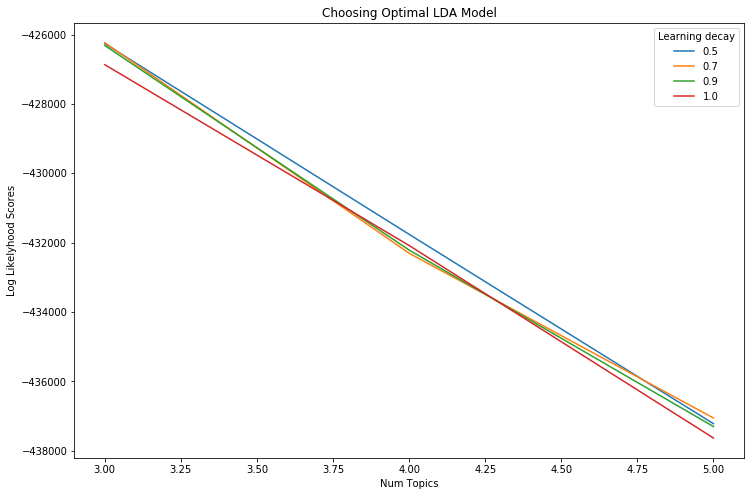

In [152]:
n_topics = [3, 4, 5]
log_likelyhoods_5 = [round(model2.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model2.cv_results_['params']) if gscore['learning_decay']==0.5]
log_likelyhoods_7 = [round(model2.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model2.cv_results_['params']) if gscore['learning_decay']==0.7]
log_likelyhoods_9 = [round(model2.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model2.cv_results_['params']) if gscore['learning_decay']==0.9]
log_likelyhoods_10 = [round(model2.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model2.cv_results_['params']) if gscore['learning_decay']==1.0]

plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.plot(n_topics, log_likelyhoods_10, label='1.0')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [142]:
n_top_words = 40
print("\nTopics in LDA model: ")
tv3_feature_names = vectorizer.get_feature_names()
print_top_words(best_lda_model, tv3_feature_names, n_top_words)


Topics in LDA model: 

Topic #0:good great sound track love really well rap make year amazing still production beat listen lyric work new bad rapper even artist favorite much nice style also far say pretty definitely hear think show fantastic overall long time hiphop feature

Topic #1:good well listen hip hop rap great time year make say get hear think ever rapper give love people fan come classic would even artist still first hiphop really new know release beat lyric way work take much track see

Topic #2:track production good great beat really make well lyric feel project flow rap feature sound listen much come still get time also overall first love even record work verse lot would seem bad hook take think way solid however amazing


In [141]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda.score(tv3))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(tv3))

# See model parameters
print(lda.get_params())

Log Likelihood:  -2021755.9530164325
Perplexity:  1082.381929199561
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 3, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 0, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [77]:
pyLDAvis.enable_notebook()

In [143]:
panel = pyLDAvis.sklearn.prepare(best_lda_model, tv3, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                 x            y  topics  cluster       Freq
topic                                                      
2     -1015.700562  1338.981201       1        1  43.610044
1      -387.996002  -373.316162       2        1  38.567523
0     -2184.745605   -60.565800       3        1  17.822434, topic_info=            Term         Freq        Total Category  logprob  loglift
1644        good  7163.000000  7163.000000  Default  30.0000  30.0000
1776         hip  1343.000000  1343.000000  Default  29.0000  29.0000
1804         hop  1333.000000  1333.000000  Default  28.0000  28.0000
3490       sound  1957.000000  1957.000000  Default  27.0000  27.0000
3878       track  4410.000000  4410.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1293        even   263.936563  1408.835074   Topic3  -5.2750   0.0499
2412        much   254.527691  1381.511638   Topic3  -5.3113   0.0332
123         also   226.902681  1115.631181   Topic3  -5.4262   0.1321
963   definitely   202.924359   784.581602   Topic3  -5.5379   0.3724
3231         say   215.343087  1576.201367   Topic3  -5.4785  -0.2658

[284 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
14        1  0.971095  absoul
101       1  0.054188     air
101       2  0.939258     air
123       1  0.512714    also
123       2  0.284144    also
...     ...       ...     ...
4212      2  0.511829   would
4212      3  0.129926   would
4222      1  0.111684    year
4222      2  0.652124    year
4222      3  0.236443    year

[475 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

Negative User Reviews

In [45]:
lemma_review2 = lemmatization(processed_rapu_neg, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(lemma_review2[8])

always spit spit ether timing pop could precise reaffirm fact duo indeed gift era gift appreciate take lesson awareness management put rtj term actually anger redirect power anger collectively use change thing well hand fist gun position right


In [91]:
# Storing the entire training text in a list
text4 = lemma_review2
# Calling our overwritten Count vectorizer

vectorizer2 = CountVectorizer(analyzer='word',       
                             min_df=5,                         
                             stop_words=stopwords_list,             
                             lowercase=True,                   
                             token_pattern='[a-zA-Z0-9]{3,}',)

tv4 = vectorizer2.fit_transform(text4)

In [124]:
# Define Search Param

# Init the Model
lda_cv3 = LatentDirichletAllocation()

# Init Grid Search Class
model3 = GridSearchCV(lda_cv3, param_grid=search_params, verbose = 1, n_jobs =-1)

# Do the Grid Search
model3.fit(tv4)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.7min finished


GridSearchCV(estimator=LatentDirichletAllocation(), n_jobs=-1,
             param_grid={'learning_decay': [0.5, 0.7, 0.9, 1.0],
                         'n_components': [3, 4, 5]},
             verbose=1)

In [125]:
# Best Model
best_lda_model2 = model3.best_estimator_

# Model Parameters
print("Best Model's Params: ", model3.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model3.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model2.perplexity(tv4))

Best Model's Params:  {'learning_decay': 1.0, 'n_components': 3}
Best Log Likelihood Score:  -76239.58785567826
Model Perplexity:  800.8585343790585


In [ ]:
n_topics = [2, 3, 4]
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.9]
log_likelyhoods_11 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.11]
log_likelyhoods_13 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.13]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.plot(n_topics, log_likelyhoods_11, label='0.11')
plt.plot(n_topics, log_likelyhoods_13, label='0.13')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [145]:
panel2 = pyLDAvis.sklearn.prepare(best_lda_model2, tv4, vectorizer2, mds='tsne')
panel2

PreparedData(topic_coordinates=                 x            y  topics  cluster       Freq
topic                                                      
0     -1015.700562  1338.981201       1        1  34.421090
2      -387.996002  -373.316162       2        1  34.362222
1     -2184.745605   -60.565800       3        1  31.216688, topic_info=       Term        Freq       Total Category  logprob  loglift
555    fire  336.000000  336.000000  Default  30.0000  30.0000
1499  track  793.000000  793.000000  Default  29.0000  29.0000
685     hip  239.000000  239.000000  Default  28.0000  28.0000
698     hop  239.000000  239.000000  Default  27.0000  27.0000
1423   suck  150.000000  150.000000  Default  26.0000  26.0000
...     ...         ...         ...      ...      ...      ...
1631  would   73.229058  272.157335   Topic3  -5.4022  -0.1486
945    much   72.295643  294.102693   Topic3  -5.4150  -0.2389
98      bad   81.540181  833.292333   Topic3  -5.2947  -1.1601
482    even   72.895450  396.891395   Topic3  -5.4068  -0.5304
628    good   72.982391  705.447423   Topic3  -5.4056  -1.1044

[248 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
11        2  0.937167  account
34        1  0.951306     alot
36        2  0.946693  alright
56        3  0.928871    apart
69        1  0.377656   artist
...     ...       ...      ...
1635      2  0.312795     year
1635      3  0.372542     year
1637      1  0.014590    young
1637      2  0.773258    young
1637      3  0.218847    young

[396 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

Positive Critic Reviews

In [59]:

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
lemma_review3 = lemmatization(processed_rapc_pos, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(lemma_review3[8])

grip part legend never die come juice speak heart


In [99]:
# Storing the entire training text in a list
text4 = lemma_review3

vectorizer3 = CountVectorizer(analyzer='word',       
                             min_df=5,                         
                             stop_words=stopwords_list,             
                             lowercase=True,                   
                             token_pattern='[a-zA-Z0-9]{3,}',)
# Calling our overwritten Count vectorizer

tv5 = vectorizer3.fit_transform(text4)

In [130]:
# Define Search Param
search_params2 = {'n_components': [3, 4, 5], 'learning_decay': [.5, .7, .9, 1.0]}

lda_cv4 = LatentDirichletAllocation()

# Init Grid Search Class
model4 = GridSearchCV(lda_cv4, param_grid=search_params2, verbose = 1, n_jobs = -1)

# Do the Grid Search
model4.fit(tv5)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.5min finished


GridSearchCV(estimator=LatentDirichletAllocation(), n_jobs=-1,
             param_grid={'learning_decay': [0.5, 0.7, 0.9, 1.0],
                         'n_components': [3, 4, 5]},
             verbose=1)

In [131]:
# Best Model
best_lda_model3 = model4.best_estimator_

# Model Parameters
print("Best Model's Params: ", model4.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model4.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model3.perplexity(tv5))

Best Model's Params:  {'learning_decay': 1.0, 'n_components': 3}
Best Log Likelihood Score:  -152178.10893560818
Model Perplexity:  1821.2604442563309


In [147]:
panel3 = pyLDAvis.sklearn.prepare(best_lda_model3, tv5, vectorizer3, mds='tsne')
panel3

PreparedData(topic_coordinates=                 x            y  topics  cluster       Freq
topic                                                      
0     -1015.700562  1338.981201       1        1  33.711545
1      -387.996002  -373.316162       2        1  33.662113
2     -2184.745605   -60.565800       3        1  32.626342, topic_info=        Term         Freq        Total Category  logprob  loglift
1306    good  1006.000000  1006.000000  Default  30.0000  30.0000
2183     pop   175.000000   175.000000  Default  29.0000  29.0000
1328   great   432.000000   432.000000  Default  28.0000  28.0000
2732   solid   189.000000   189.000000  Default  27.0000  27.0000
3042    time   484.000000   484.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
532     come   133.809070   428.532161   Topic3  -5.4241  -0.0439
1900    much   131.779079   418.939563   Topic3  -5.4394  -0.0365
3069   track   149.737926   611.213218   Topic3  -5.3116  -0.2865
2331  rapper   121.039783   365.813554   Topic3  -5.5244   0.0140
1306    good   110.102692  1006.166439   Topic3  -5.6191  -1.0924

[256 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
19        1  0.977914   accomplish
23        3  0.948466  achievement
47        2  0.966625    adventure
79        1  0.371108         also
79        2  0.140765         also
...     ...       ...          ...
3328      2  0.284376         work
3328      3  0.348012         work
3345      1  0.480298         year
3345      2  0.430690         year
3345      3  0.087942         year

[370 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

Negative Critic Reviews

In [69]:
lemma_review4 = lemmatization(processed_rapc_neg, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(lemma_review4[8])

hardly dry academic palpable anger course track latter feature feel cleanse acid bath fury sensation group articulates emotionally complex far


In [106]:
# Storing the entire training text in a list
text5 = lemma_review4

vectorizer4 = CountVectorizer(analyzer='word',       
                             min_df=5,                         
                             stop_words=stopwords_list,             
                             lowercase=True,                   
                             token_pattern='[a-zA-Z0-9]{3,}',)
# Calling our overwritten Count vectorizer

tv6 = vectorizer4.fit_transform(text5)

In [132]:
# Define Search Param

lda_cv5 = LatentDirichletAllocation()

# Init Grid Search Class
model5 = GridSearchCV(lda_cv5, param_grid=search_params2, verbose = 1, n_jobs = -1)

# Do the Grid Search
model5.fit(tv6)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.4min finished


GridSearchCV(estimator=LatentDirichletAllocation(), n_jobs=-1,
             param_grid={'learning_decay': [0.5, 0.7, 0.9, 1.0],
                         'n_components': [3, 4, 5]},
             verbose=1)

In [133]:
# Best Model
best_lda_model4 = model5.best_estimator_

# Model Parameters
print("Best Model's Params: ", model5.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model5.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model4.perplexity(tv6))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 3}
Best Log Likelihood Score:  -46850.528759057066
Model Perplexity:  1313.730876994048


In [149]:
panel4 = pyLDAvis.sklearn.prepare(best_lda_model4, tv6, vectorizer4, mds='tsne')
panel4

PreparedData(topic_coordinates=                 x            y  topics  cluster       Freq
topic                                                      
0     -1015.700562  1338.981201       1        1  33.921856
2      -387.996002  -373.316162       2        1  33.855933
1     -2184.745605   -60.565800       3        1  32.222211, topic_info=            Term        Freq       Total Category  logprob  loglift
699         hard  122.000000  122.000000  Default  30.0000  30.0000
919         make  334.000000  334.000000  Default  29.0000  29.0000
1215     release   83.000000   83.000000  Default  28.0000  28.0000
965       minute   65.000000   65.000000  Default  27.0000  27.0000
724          hit   69.000000   69.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
1007         new   40.588986   96.391444   Topic3  -5.4349   0.2676
860        leave   38.267174   81.252429   Topic3  -5.4938   0.3795
987         much   45.453165  188.039629   Topic3  -5.3217  -0.2875
504         even   41.363012  171.938441   Topic3  -5.4160  -0.2922
1144  production   38.866593  144.542788   Topic3  -5.4782  -0.1809

[235 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
35        2  0.982296    almost
58        2  0.964521  approach
66        2  0.952080       art
66        3  0.052893       art
88        2  0.940332   awkward
...     ...       ...       ...
1677      2  0.822979     write
1681      1  0.394973      year
1681      2  0.434470      year
1681      3  0.173788      year
1684      1  0.982112     young

[317 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])